## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit 
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import time
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from scipy import stats as st
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder 

In [2]:
# загружаем данные
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
# смотри общую информацию
display(data.info())
display(data.head(10))
display(data.describe())
print('Кол-во пропусков:', data.isna().sum())
print('Дубликатов:', data.duplicated().sum())
print('Размер датасета:', data.shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Кол-во пропусков: num_orders    0
dtype: int64
Дубликатов: 26415
Размер датасета: (26496, 1)


In [4]:
data.index.is_monotonic

True

In [5]:
data.sort_index(inplace=True)

In [6]:
data = data.resample('1H').sum()
display(data.head(10))

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


<AxesSubplot:xlabel='datetime'>

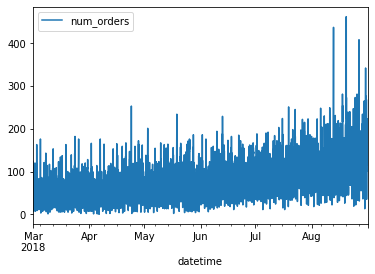

In [7]:
data.plot()

Дубликатов нет, пропусков нет. Проверили данные на монотонность.Провели ресемплинг с диапозоном в 1 час ,где данные агрегировали с помощью суммы. Посмотрели на данные с количеством вызовов за каждый час - данные имеют большую частоту.

## Анализ

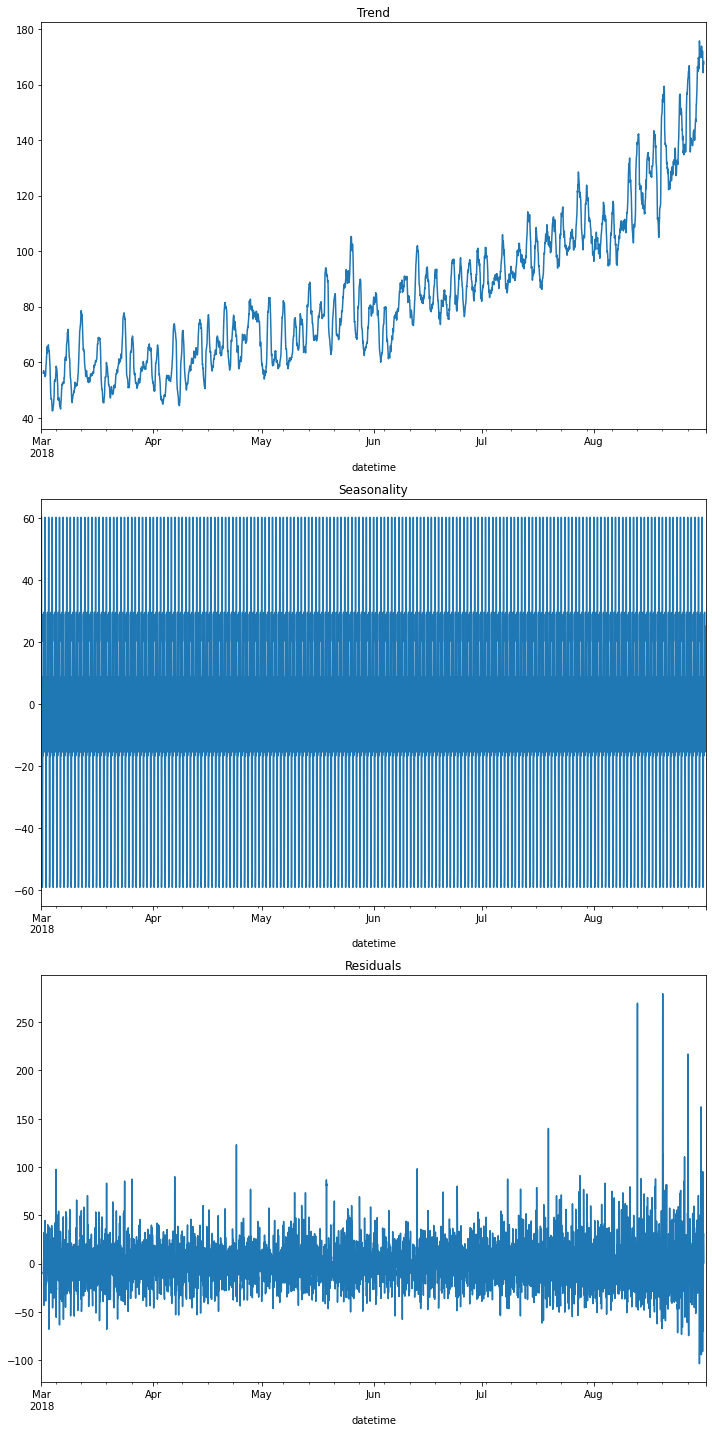

In [8]:
# разложим временной ряд на три составляющие: тренд, сезонность и остаток
decomposed = seasonal_decompose(data)

plt.figure(figsize=(10, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Графики показывают высокую частотность и суточную сезонность

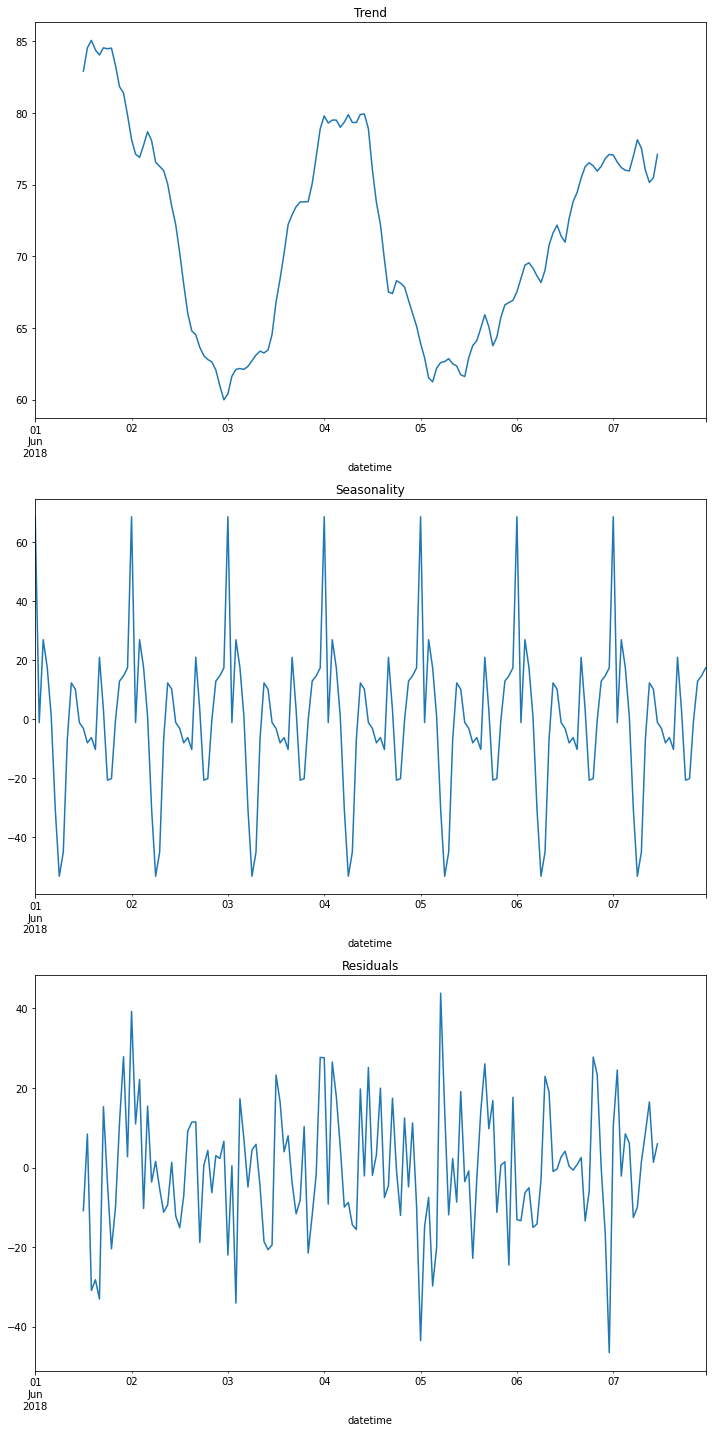

In [9]:
# уменьшим интервал и посмотрим за неделю:
decomposed = seasonal_decompose(data['2018-06-01':'2018-06-07'])

plt.figure(figsize=(10, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

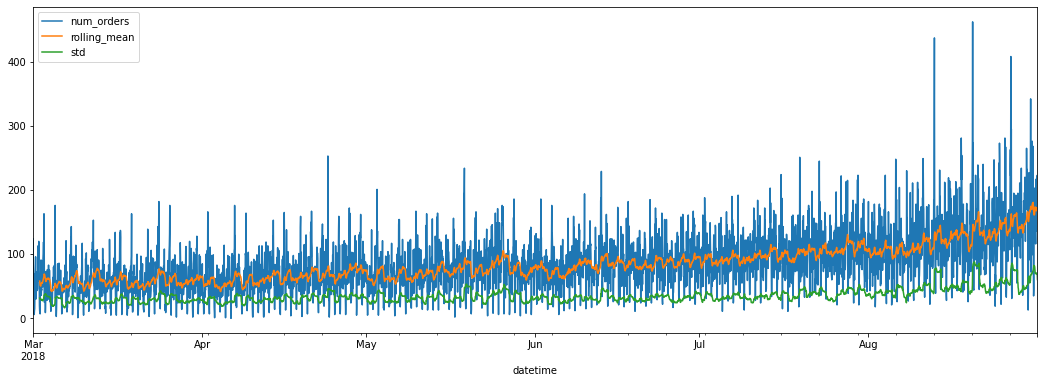

In [10]:
data_plot = data.copy()
data_plot['rolling_mean'] = data_plot.rolling(30).mean()
data_plot['std'] = data_plot['num_orders'].rolling(30).std()
data_plot.plot(figsize=(18, 6))

<AxesSubplot:xlabel='datetime'>

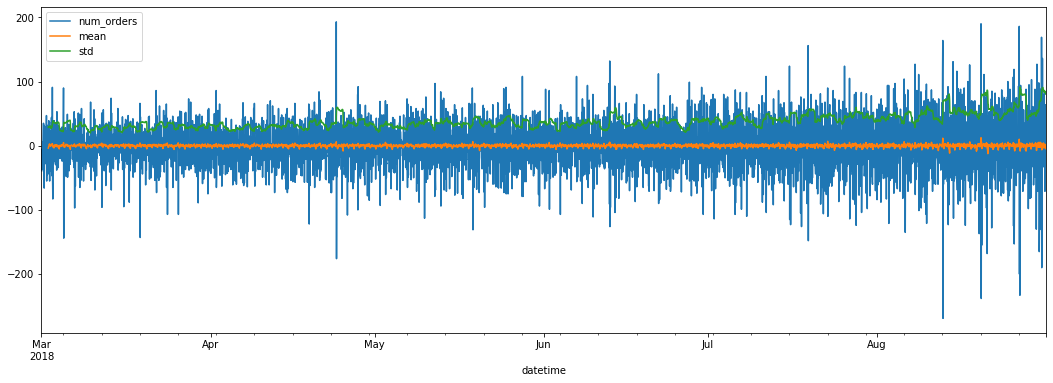

In [11]:
data_shift = data - data.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(30).mean()
data_shift['std'] = data_shift['num_orders'].rolling(30).std()
data_shift.plot(figsize=(18, 6))

<b>Вывод:</b>
<p>Методом декомпозиции было выявлено:
<p>- в летний период количество заказов растет;
<p>- слабый спрос по средам и пятницам;

## Обучение

In [12]:
#напишем функцию для создания признаков:
def make_features(data, max_lag, rolling_sum_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
   
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_sum'] = data['num_orders'].shift().rolling(rolling_sum_size).mean()

In [13]:
#применим функцию с лагом до 24 часов, скользящим средним - 100:
make_features(data, 24, 100)

In [14]:
#делим данные на выборки:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

In [15]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3874, 28)
(442, 28)
(3874,)
(442,)


In [16]:
#напишем функцию для расчёта RMSE:
def rmse(target, predict):
    return ((mean_squared_error(target, predict))**0.5).round(2)

### Модель LinearRegression

In [17]:
%%time
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

CPU times: user 15.4 ms, sys: 56.4 ms, total: 71.8 ms
Wall time: 22.6 ms


LinearRegression()

### Модель CatBoostRegressor

In [19]:
%%time
time_cv = TimeSeriesSplit(n_splits=3).split(features_train)
model_cat = CatBoostRegressor() 
parametrs_cat = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10]
                }
grid_cat = GridSearchCV(model_cat, parametrs_cat, scoring='neg_mean_squared_error', cv=time_cv)
grid_cat.fit(features_train, target_train, verbose=100)

0:	learn: 28.8713227	total: 51.8ms	remaining: 51.8s
100:	learn: 17.8746531	total: 226ms	remaining: 2.01s
200:	learn: 16.1651223	total: 388ms	remaining: 1.54s
300:	learn: 14.9694226	total: 576ms	remaining: 1.34s
400:	learn: 13.8168232	total: 758ms	remaining: 1.13s
500:	learn: 12.8077538	total: 926ms	remaining: 922ms
600:	learn: 11.9538974	total: 1.1s	remaining: 729ms
700:	learn: 11.1219348	total: 1.26s	remaining: 537ms
800:	learn: 10.4442542	total: 1.43s	remaining: 354ms
900:	learn: 9.7931804	total: 1.6s	remaining: 176ms
999:	learn: 9.2389981	total: 1.8s	remaining: 0us
0:	learn: 31.8800562	total: 2.62ms	remaining: 2.62s
100:	learn: 20.1892408	total: 235ms	remaining: 2.1s
200:	learn: 18.4757691	total: 465ms	remaining: 1.85s
300:	learn: 17.4328868	total: 679ms	remaining: 1.58s
400:	learn: 16.5943976	total: 911ms	remaining: 1.36s
500:	learn: 15.8497977	total: 1.13s	remaining: 1.13s
600:	learn: 15.2197744	total: 1.35s	remaining: 899ms
700:	learn: 14.6545936	total: 1.57s	remaining: 670ms
800

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fd7fe9dbac0>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fd7fe66aac0>,
             param_grid={'depth': [4, 6, 10], 'learning_rate': [0.03, 0.1]},
             scoring='neg_mean_squared_error')

In [20]:
%%time
params_cat = grid_cat.best_params_
score_cat = grid_cat.score(features_train, target_train) * (-1)
print(params_cat)
print(score_cat)

{'depth': 6, 'learning_rate': 0.03}
192.5122719683137
CPU times: user 9.94 ms, sys: 26 µs, total: 9.96 ms
Wall time: 7.75 ms


In [21]:
%%time
#подставляем лучшие параметры:
model_cat = CatBoostRegressor(learning_rate=.03, depth=6, random_state=12345, verbose=False)
model_cat.fit(features_train, target_train)

CPU times: user 5.76 s, sys: 133 ms, total: 5.9 s
Wall time: 6.61 s


### Модель LightGBMRegressor

In [23]:
%%time
time_cv = TimeSeriesSplit(n_splits=3).split(features_train)
model_LGB = LGBMRegressor() 
parameters_LGB = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5], 'random_state':[12345]}]

grid_LGB = GridSearchCV(model_LGB, parameters_LGB, scoring='neg_mean_squared_error', cv=time_cv)
grid_LGB.fit(features_train, target_train, verbose=100)

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. 

CPU times: user 42min 46s, sys: 29.5 s, total: 43min 16s
Wall time: 43min 29s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7fd7fe9db580>,
             estimator=LGBMRegressor(),
             param_grid=[{'learning_rate': [0.1, 0.3, 0.5],
                          'num_leaves': [25, 50, 100, 200],
                          'random_state': [12345]}],
             scoring='neg_mean_squared_error')

In [24]:
%%time
params_LGB = grid_LGB.best_params_
score_LGB = grid_LGB.score(features_train, target_train) * (-1)
print(params_LGB)
print(score_LGB)

{'learning_rate': 0.1, 'num_leaves': 25, 'random_state': 12345}
178.92330902150016
CPU times: user 73.4 ms, sys: 192 µs, total: 73.6 ms
Wall time: 20.9 ms


In [25]:
%%time
#подставляем лучшие параметры:
model_LGB = LGBMRegressor(num_leaves=25, learning_rate=.1, random_state=12345)
model_LGB.fit(features_train, target_train)

CPU times: user 24.1 s, sys: 169 ms, total: 24.3 s
Wall time: 24.5 s


LGBMRegressor(num_leaves=25, random_state=12345)

## Тестирование

### Модель LinearRegression

In [26]:
%%time
predict_lr = model_lr.predict(features_train)
rmse_lr = rmse(target_train, predict_lr)
print('RMSE модели LinearRegression = ', rmse_lr)

RMSE модели LinearRegression =  25.82
CPU times: user 17.9 ms, sys: 162 µs, total: 18.1 ms
Wall time: 5.01 ms


### Модель CatBoostRegressor

In [27]:
%%time
predict_cat = model_cat.predict(features_train)
rmse_cat = rmse(target_train, predict_cat)
print('RMSE модели CatBoostRegressor = ', rmse_cat)

RMSE модели CatBoostRegressor =  13.96
CPU times: user 7.42 ms, sys: 8.15 ms, total: 15.6 ms
Wall time: 12.9 ms


### Модель LightGBMRegressor

In [28]:
%%time
predict_LGB = model_LGB.predict(features_train)
rmse_LGB = rmse(target_train, predict_LGB)
print('RMSE модели  LightGBMRegressor = ', rmse_LGB)

RMSE модели  LightGBMRegressor =  13.38
CPU times: user 47.7 ms, sys: 0 ns, total: 47.7 ms
Wall time: 9.43 ms


<b>Вывод: </b>
<p>Обучили 3 модели - LinearRegression, CatBoostRegressor и LGBMRegressor; 
    <p>Все моджели показали RMSE < 48
<p>- Модель LinearRegression показала: RMSE=25,82, время обучения - 22,6мс, время предсказания - 5,01мс.
<p>- Модель CatBoostRegressor показала: RMSE=13,96, время обучения - 6,61с, время предсказания -  12,9мс.
<p>- Модель LGBMRegressor показала: RMSE=13,38, время обучения 24,5с, время предсказания - 9,43мс.
<p>Таким образом, лучшей моделью, которая спрогнозирует количество заказов такси на следующий час, предлагем выбрать модель LGBMRegressor

### Тестирование лучшей модели

In [29]:
%%time
predict_LGB = model_LGB.predict(features_test)
rmse_LGB = rmse(target_test, predict_LGB)
print('RMSE модели  LightGBMRegressor = ', rmse_LGB)

RMSE модели  LightGBMRegressor =  40.84
CPU times: user 53.7 ms, sys: 9 µs, total: 53.7 ms
Wall time: 12 ms


## Вывод

<p>В процессе обработки данных: дубликаты не выявлены, пропусков нет. Проверили данные на монотонность.Провели ресемплинг с диапозоном в 1 час ,где данные агрегировали с помощью суммы. 
<p>Методом декомпозиции было выявлено:
<p>- в летний период количество заказов растет;
<p>- слабый спрос по средам и пятницам;
<p>Обучили 3 модели - LinearRegression, CatBoostRegressor и LGBMRegressor; 
<p>Все моджели показали RMSE < 48
<p>- Модель LinearRegression показала: RMSE=25,82, время обучения - 22,6мс, время предсказания - 5,01мс.
<p>- Модель CatBoostRegressor показала: RMSE=13,96, время обучения - 6,61с, время предсказания -  12,9мс.
<p>- Модель LGBMRegressor показала: RMSE=13,38, время обучения 24,5с, время предсказания - 9,43мс.

<p>Лучшей моделью, которая спрогнозирует количество заказов такси на следующий час, выбрали модель LGBMRegressor, которая на тестировании показала RMSE=40,84.

